In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications import ResNet50

# Loading Extraced features from VGG16

In [3]:
# load features from pickle
with open('D:/Coding/Hackathons/Innocodathon/Code-notebooks/notebooks/archive/features.pkl', 'rb') as f:
    features = pickle.load(f)

# Processing Captions

In [6]:
# Assuming the file is in the same directory as your script
with open('D:/Coding/Hackathons/Innocodathon/Code-notebooks/notebooks/archive/captions.csv', 'r') as f:
    # next(f)  # Skip the first line
    captions_doc = f.read()


In [7]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/11937 [00:00<?, ?it/s]

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
mapping['0']

[' An office with multiple people working.',
 ' People Standing.',
 ' An office environment.',
 ' A man entering the office.',
 ' People working.']

In [10]:
# preprocess the text
clean(mapping)

In [11]:
mapping['0']

['startseq an office with multiple people working. endseq',
 'startseq people standing. endseq',
 'startseq an office environment. endseq',
 'startseq man entering the office. endseq',
 'startseq people working. endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

11936

In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

5217

In [16]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

83

# Making Train test split ...

due to the notification of seperate test data only 2 % has been allocated to test 

In [17]:
import random

image_ids = list(mapping.keys())

# Randomly shuffle the image IDs to ensure fair distribution across sets
random.shuffle(image_ids)

# Calculate the split point based on the desired split ratio (90% train, 10% test)
split_point = int(len(image_ids) * 0.98)

# Use slicing to create training and testing sets
train = image_ids[:split_point]
test = image_ids[split_point:]

print("Training set:", train)
print("Testing set:", test)

Training set: ['1576', '968', '1687', '1221', '2288', '506', '530', '1677', '929', '2085', '2049', '251', '1674', '1772', '1010', '765', '1211', '1748', '1253', '310', '2129', '1815', '2153', '1800', '1256', '497', '463', '836', '51', '110', '1495', '1122', '735', '955', '657', '30', '1227', '1161', '1107', '2379', '817', '1898', '1704', '744', '131', '1469', '2139', '1412', '1608', '1596', '1699', '1376', '2326', '375', '692', '2205', '1891', '2213', '239', '2148', '395', '1189', '560', '223', '1379', '790', '2317', '1347', '1834', '680', '98', '2086', '1945', '575', '1084', '292', '2132', '125', '1631', '687', '2105', '1484', '601', '591', '1828', '1835', '362', '1078', '461', '2095', '2301', '276', '1481', '2411', '1936', '932', '2104', '935', '293', '915', '2162', '1690', '2076', '118', '274', '1171', '264', '919', '1532', '2383', '2043', '1994', '2128', '1843', '2336', '1352', '2011', '1678', '17', '2294', '1909', '1645', '618', '1052', '398', '1771', '776', '1575', '2027', '376',

In [18]:
def filter_train_by_features(features, train):
  """
  Filters the train list to only include items whose keys are present in the features dictionary.

  Args:
      features: A dictionary containing key-value pairs.
      train: A list of items.

  Returns:
      A new list containing only items from train whose keys are present in features.
  """
  return [item for item in train if item in features]

# # Example usage
# features = {"a": 1, "b": 2, "c": 3}
# train = ["a", "x", "b", "y", "c"]

filtered_train = filter_train_by_features(features, train)
print(filtered_train)

['1576', '968', '1687', '1221', '2288', '506', '530', '1677', '929', '2085', '2049', '251', '1674', '1772', '1010', '765', '1211', '1748', '1253', '310', '2129', '1815', '2153', '1800', '1256', '497', '463', '836', '51', '110', '1495', '1122', '735', '955', '657', '30', '1227', '1161', '1107', '2379', '817', '1898', '1704', '744', '131', '1469', '2139', '1412', '1608', '1596', '1699', '1376', '2326', '375', '692', '2205', '1891', '2213', '239', '2148', '395', '1189', '560', '223', '1379', '790', '2317', '1347', '1834', '680', '98', '2086', '1945', '575', '1084', '292', '2132', '125', '1631', '687', '2105', '1484', '601', '591', '1828', '1835', '362', '1078', '461', '2095', '2301', '276', '1481', '2411', '1936', '932', '2104', '935', '293', '915', '2162', '1690', '2076', '118', '274', '1171', '264', '919', '1532', '2383', '2043', '1994', '2128', '1843', '2336', '1352', '2011', '1678', '17', '2294', '1909', '1645', '618', '1052', '398', '1771', '776', '1575', '2027', '376', '2097', '644'

In [19]:
filtered_test = filter_train_by_features(features, test)
filtered_test

['2396',
 '738',
 '1530',
 '567',
 '1952',
 '2204',
 '489',
 '2373',
 '2409',
 '1385',
 '2102',
 '1565',
 '1182',
 '1558',
 '94',
 '2221',
 '798',
 '498',
 '154',
 '1579',
 '1326',
 '1625',
 '1478',
 '1468',
 '353',
 '1361',
 '1899',
 '1629',
 '2037',
 '402',
 '895',
 '1450',
 '760',
 '354',
 '393',
 '2283',
 '1443',
 '507',
 '2385',
 '2272',
 '720',
 '906',
 '1011',
 '667',
 '1197',
 '314',
 '1173',
 '747']

In [20]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Creating the model

In [21]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Training the model

In [23]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(filtered_train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

73/73 [==============================] - 525s 7s/step - loss: 1.0500


In [25]:
# train the model
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(filtered_train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 1/73 [..............................] - ETA: 10:37 - loss: 1.1629

KeyboardInterrupt: 

# Loss Curve

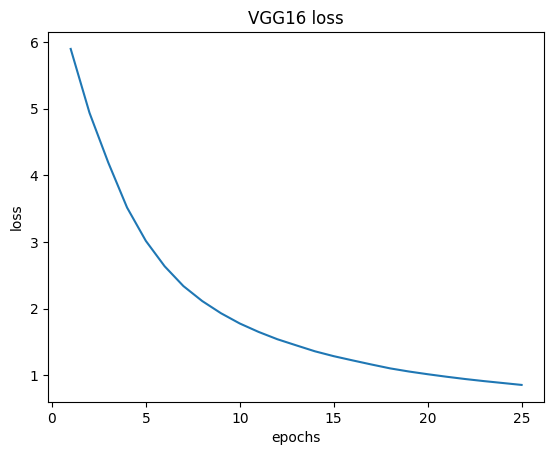

In [26]:
import matplotlib.pyplot as plt

x = [i for i in range(1,26)]
y = [5.8986,4.9398,4.1923,3.5169,3.0166,2.6356,2.3379,2.1135,1.9303,1.7765,1.6502,1.5402,1.4488,1.3590,1.2859,1.2228,1.1614,1.1027,1.0557,1.0150,0.9774,0.9427,0.9115,0.8829,0.8543]

plt.plot(x, y)

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('VGG16 loss')

# Show the plot
plt.show()

In [27]:
# save the model
model.save('best_model.h5')

c:\Users\Priyanshu Aggarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.h5')

# Now you can use this model for predictions or any other purposes


In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(filtered_test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)



ModuleNotFoundError: No module named 'nltk'

In [34]:
actual, predicted = list(), list()


for key in tqdm(filtered_test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.712313
BLEU-2: 0.566585


In [35]:
str_predicted = [' '.join(inner_list) for inner_list in predicted]
str_predicted

['startseq shelf wielding hero takes on thief endseq',
 'startseq the person tightly clutches rod emphasizing the gravity of the unfolding conflict endseq',
 'startseq the man enters the scene endseq',
 'startseq in the midst of the tumult personal belongings are discarded in the race to escape endseq',
 'startseq the weathered floorboards bear witness to person in blue finding solace on their surface the image conveys the beauty of simplicity and the strength of quiet reflection creating timeless connection with the surroundings endseq',
 'startseq the individual dressed in white is seen initiating physical confrontation endseq',
 'startseq the lobby becomes dramatic stage for the company heightening the tension of the unfolding conflict endseq',
 'startseq cctv cartography snack expedition endseq',
 'startseq shelf wielding hero takes on thief endseq',
 "startseq the fallen figure lies on the ground shouting between fallen bike and bicycle amid the car's situation is beat the car's f

In [36]:
str_actual = [
    ' '.join(inner_list)  # Join words in each inner list
    for outer_list in actual  # Iterate through outer lists
    for inner_list in outer_list  # Iterate through inner lists containing captions
]
print(str_actual)


['startseq courage in crisis: shopkeeper faces armed danger. endseq', 'startseq defending the store with determination. endseq', 'startseq high-tension moment in aisle 5. endseq', 'startseq shelf-battle: store owner takes on thief. endseq', 'startseq retailer? heroic response to robbery. endseq', 'startseq heightened sense of chaos envelops the lobby as people frantically exit creating scene of urgency." endseq', 'startseq the ongoing altercation on the staircase draws the attention of onlookers in the crowded lobby. endseq', 'startseq the person tightly clutches rod emphasizing the gravity of the unfolding events on the staircase." endseq', 'startseq the chaotic scene in the lobby reflects the intensity of the unfolding conflict amplifying the drama." endseq', 'startseq the struggle on the staircase persists with both parties unwilling to back down or reach resolution." endseq', 'startseq the prone figure of man rests near motorcycle. endseq', 'startseq blood seeps from the man\'s wou

In [ ]:
from rouge_score import rouge_scorer


In [37]:
sum=0

n=0
for j in range(48):
  rouge=[]
  for i in range(5*n,5*n+5):
    scorer=rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    scores = scorer.score(str_predicted[j], str_actual[i])
    rouge.append(scores['rouge1'].precision)
    # print(i)
  n+=1
  sum+=max(rouge)

print(sum/48)

NameError: name 'rouge_scorer' is not defined